In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import re
import seaborn as sns


In [2]:
#df = pd.read_csv('../input/train.csv')
#df_test = pd.read_csv('../input/test.csv')
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print("Cols: ", df.columns)

print("Cab", len(df[df['Cabin'].isnull()][['Cabin', 'Name' ]]))
print("Emb", len(df[df['Embarked'].isnull()][['Embarked', 'Name' ]]))
print("Sex", len(df[df['Sex'].isnull()][['Sex', 'Name' ]]))
print("Age", len(df[df['Age'].isnull()][['Age', 'Name' ]]))
print("Par", len(df[df['Parch'].isnull()][['Parch', 'Name' ]]))
print("Sib", len(df[df['SibSp'].isnull()][['SibSp', 'Name' ]]))
print("Far", len(df[df['Fare'].isnull()][['Fare', 'Name' ]]))
print("Tic", len(df[df['Ticket'].isnull()][['Ticket', 'Name' ]]))
print("Pcl", len(df[df['Pclass'].isnull()][['Pclass', 'Name' ]]))

# Filling NAs
df["Embarked"] = df["Embarked"].fillna('C')

# Fill missing fields with columns means
df = df.fillna(df.mean())
df['Cabin'] = df['Cabin'].fillna('U')

# Fill missing fields with columns means
df_test = df_test.fillna(df_test.mean())
df_test['Cabin'] = df_test['Cabin'].fillna('U')


# Extracting numeric part from tickets and creating a new feature
ticketnos = []
for s in df['Ticket']:
    ticketnos.append(''.join([n for n in s.split() if n.isdigit()]))
df['TicketNo'] = pd.to_numeric(pd.Series(ticketnos))
df['TicketNo'] = df['TicketNo'].fillna(df['TicketNo'].median())

ticketnos = []
for s in df_test['Ticket']:
    ticketnos.append(''.join([n for n in s.split() if n.isdigit()]))
df_test['TicketNo'] = pd.to_numeric(pd.Series(ticketnos))


print(df.describe())
print(df.dtypes)

# Transforming cabin code to a deck, adding 'U' (unknown) for the missing ones
df['Deck'] = pd.Series([re.split('(\d.*)',s)[0][0] for s in df['Cabin']])
df_test['Deck'] = pd.Series([re.split('(\d.*)',s)[0][0] for s in df_test['Cabin']])



Cols:  Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Cab 687
Emb 2
Sex 0
Age 177
Par 0
Sib 0
Far 0
Tic 0
Pcl 0
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   13.002015    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   22.000000    0.000000   
50%     446.000000    0.000000    3.000000   29.699118    0.000000   
75%     668.500000    1.000000    3.000000   35.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare      TicketNo  
count  891.000000  891.000000  8.910000e+02  
mean     0.381594   32.204208  2.974932e+05  
std      0.80

## Adding new features

Here I try to add some more features in order to take the most from this small dataset

[(18, 23], (23, 55], (0, 18], (55, 80]]
Categories (4, object): [(0, 18] < (18, 23] < (23, 55] < (55, 80]]
[(-1, 2], (2, 5], (5, 7], (7, 11]]
Categories (4, object): [(-1, 2] < (2, 5] < (5, 7] < (7, 11]]
[(20, 40], (40, 57], (0, 20], (57, 85]]
Categories (4, object): [(0, 20] < (20, 40] < (40, 57] < (57, 85]]


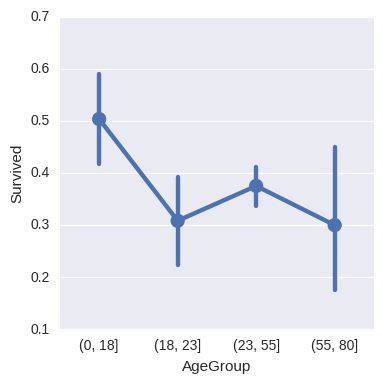

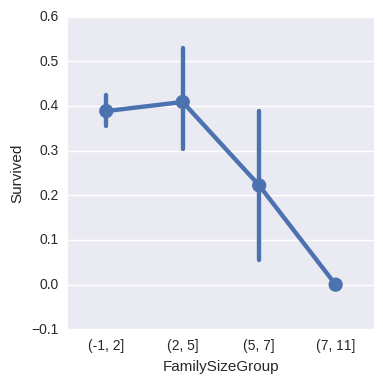

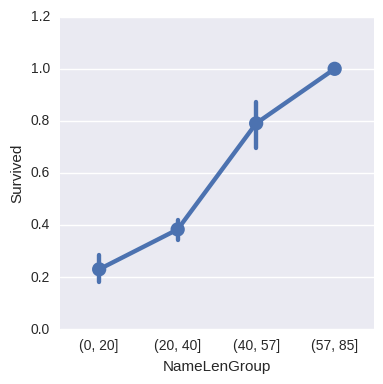

In [3]:
#--------------------
# Under-18 feature
df['U18'] = df['Age'] < 18
df_test['U18'] = df_test['Age'] < 18

bins = [0, 18, 23, 55, 80]
df['AgeGroup'] = pd.cut(df['Age'], bins)
df_test['AgeGroup'] = pd.cut(df_test['Age'], bins)

sns.factorplot(x="AgeGroup", y="Survived", data=df)
print(df["AgeGroup"].unique())

#--------------------
# Family size
df['FamilySize'] = (df['Parch'] + df['SibSp'])
df_test['FamilySize'] = (df_test['Parch'] + df_test['SibSp'])

bins = [-1, 2, 5, 7, 11]
df['FamilySizeGroup'] = pd.cut(df['FamilySize'], bins)
df_test['FamilySizeGroup'] = pd.cut(df_test['FamilySize'], bins)

sns.factorplot(x="FamilySizeGroup", y="Survived", data=df)
print(df["FamilySizeGroup"].unique())

#--------------------
# Name length
df['NameLen'] = [len(n) for n in df['Name']]
df_test['NameLen'] = [len(n) for n in df_test['Name']]

bins = [0, 20, 40, 57, 85]
df['NameLenGroup'] = pd.cut(df['NameLen'], bins)
df_test['NameLenGroup'] = pd.cut(df_test['NameLen'], bins)

sns.factorplot(x="NameLenGroup", y="Survived", data=df)
print(df["NameLenGroup"].unique())
#--------------------



### Titles
Let's extract a feature representing passengers' titles to see how it influences the survival rate.


In [4]:
titles = ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Dr.', 'Col.', 'Capt.', 'Sir.', 'Lady.', 'Countess.', 'Dona.'
          , 'Major.', 'Don.', 'Rev.', 'Father', 'Jonkheer.', 'Mlle.', 'Ms.', 'Mme.']

df['Title'] = df['Name'].apply(lambda n: str(set([w for w in n.split()]) & set(titles)) )
df_test['Title'] = df_test['Name'].apply(lambda n: str(set([w for w in n.split()]) & set(titles)) )

df['Title'].unique()
df_test['Title'].unique()

#df['Name'][df['Title']=='set()']
#df_test['Name'][df_test['Title']=='set()']

array(["{'Mr.'}", "{'Mrs.'}", "{'Miss.'}", "{'Master.'}", "{'Ms.'}",
       "{'Col.'}", "{'Rev.'}", "{'Dr.'}", "{'Dona.'}"], dtype=object)

# Labeling

In [5]:

labels = ['Sex', 'Embarked', 'Deck', 'NameLenGroup', 'FamilySizeGroup', 'AgeGroup', 'Title']
les = {}

for l in labels:
    print('labeling ' + l)
    les[l] = LabelEncoder()
    #print(df[l])
    les[l].fit(df[l].append(df_test[l]))
    tr = les[l].transform(df[l]) 
    df.loc[:, l + '_feat'] = pd.Series(tr, index=df.index)

    tr_test = les[l].transform(df_test[l]) 
    df_test.loc[:, l + '_feat'] = pd.Series(tr_test, index=df_test.index)


#print(df.head())

labeling Sex
labeling Embarked
labeling Deck
labeling NameLenGroup
labeling FamilySizeGroup
labeling AgeGroup
labeling Title


## Preparing datasets

In [6]:
X_train = df.drop(labels, 1) \
    .drop('Survived', 1) \
    .drop('Cabin', 1) \
    .drop('Ticket', 1) \
    .drop('NameLen', 1) \
    .drop('Name', 1) \
    .drop('PassengerId', 1)
y_train = df['Survived']

X_test = df_test.drop(labels, 1) \
    .drop('Cabin', 1) \
    .drop('Ticket', 1) \
    .drop('NameLen', 1) \
    .drop('Name', 1) \
    .drop('PassengerId', 1)

print("X_train shape", X_train.shape)
print("X_test  shape", X_test.shape)

#X_train.describe()
#X_test.describe()


X_train shape (891, 15)
X_test  shape (418, 15)


## Some visualizations

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Survived                1.000000
Sex_feat                0.543351
Pclass                  0.338481
Deck_feat               0.301116
NameLenGroup_feat       0.297221
Fare                    0.257307
Title_feat              0.198170
Embarked_feat           0.174199
U18                     0.122239
TicketNo                0.095844
AgeGroup_feat           0.082494
FamilySizeGroup_feat    0.062015
FamilySize              0.016639
Name: Survived, dtype: float64

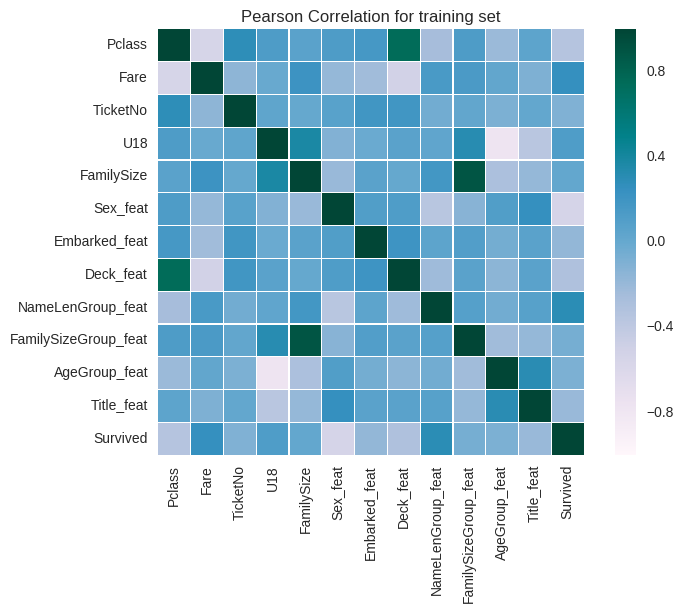

In [62]:

full_set = X_train[:]
full_set['Survived'] = y_train

plt.title('Pearson Correlation for training set')
sns.heatmap(full_set.astype(float).corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True, 
            cmap="PuBuGn", 
            linecolor='w', 
            annot=False)

full_set.corr()['Survived'].abs().sort_values(ascending = False)

TODO: I'll try to remove Age, SibSp and Parch from the training set because they seem to be very less related to the Survival than the other features

In [8]:
X_train = X_train.drop('Age', 1) \
    .drop('SibSp', 1) \
    .drop('Parch', 1) 

X_test = X_test.drop('Age', 1) \
    .drop('SibSp', 1) \
    .drop('Parch', 1) 


In [67]:
def dummies(train, test, columns ):
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test
X_train, X_test = dummies(X_train, X_test, columns=['Pclass'
                                                    , 'Sex_feat'
                                                    , 'Embarked_feat'
                                                    , 'Deck_feat'
                                                    , 'TicketNo'
                                                    , 'Title_feat'
                                                    , 'AgeGroup_feat'
                                                    , 'FamilySizeGroup_feat'
                                                    , 'NameLenGroup_feat'])

In [69]:
full_set = X_train[:]
full_set['Survived'] = y_train

full_set.corr()['Survived'].abs().sort_values(ascending = False)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Survived                  1.000000
Title_feat_13             0.549199
Sex_feat_1                0.543351
Sex_feat_0                0.543351
Title_feat_14             0.339040
Title_feat_10             0.327093
Pclass_3                  0.322308
Deck_feat_8               0.316912
Pclass_1                  0.285904
NameLenGroup_feat_2       0.273448
Fare                      0.257307
NameLenGroup_feat_0       0.193143
Deck_feat_1               0.175095
Embarked_feat_0           0.174718
Embarked_feat_2           0.155660
Deck_feat_3               0.150716
Deck_feat_4               0.145321
U18                       0.122239
Deck_feat_2               0.114652
AgeGroup_feat_0           0.105873
Pclass_2                  0.093349
Title_feat_9              0.085221
NameLenGroup_feat_3       0.085083
FamilySizeGroup_feat_3    0.070234
Title_feat_16             0.064988
Deck_feat_5               0.057935
AgeGroup_feat_1           0.057298
FamilySizeGroup_feat_2    0.047719
Title_feat_15       

# Training some models

I split the set in a training set and a validation set in order to check the algorithm score once trained

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import math

X_tr, X_ts, y_tr, y_ts = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
print(X_tr.shape, y_tr.shape, X_ts.shape, y_ts.shape)


(596, 12) (596,) (295, 12) (295,)


#### Random forest

In [72]:
from sklearn.ensemble import RandomForestClassifier


In [75]:
rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10, 12, 16], "n_estimators": [50, 100, 400, 700, 1000]}
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
gs = gs.fit(X_train.iloc[:, 1:], X_train.iloc[:, 0])
print(gs.bestscore)
print(gs.bestparams)
print(gs.cvresults)


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/opt/conda/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/opt/conda/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7fd4fb12bc90, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/opt/conda/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/opt/conda/lib/python3.5/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7fd4fb12bc90, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/opt/conda/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/opt/conda/lib/python3.5/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/opt/conda/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/opt/conda/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/opt/conda/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/opt/conda/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/opt/conda/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/opt/conda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/opt/conda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/opt/conda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/opt/conda/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/opt/conda/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/opt/conda/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "rf = RandomForestClassifier(max_features='auto',...tscore)\nprint(gs.bestparams)\nprint(gs.cvresults)\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-02-03T21:11:13.328048', 'msg_id': 'D3E4D2F6C206487485DA1121188CE021', 'msg_type': 'execute_request', 'session': '0FF96C21B9834467B758AD9612F5C112', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'D3E4D2F6C206487485DA1121188CE021', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'0FF96C21B9834467B758AD9612F5C112']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "rf = RandomForestClassifier(max_features='auto',...tscore)\nprint(gs.bestparams)\nprint(gs.cvresults)\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-02-03T21:11:13.328048', 'msg_id': 'D3E4D2F6C206487485DA1121188CE021', 'msg_type': 'execute_request', 'session': '0FF96C21B9834467B758AD9612F5C112', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'D3E4D2F6C206487485DA1121188CE021', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/opt/conda/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'0FF96C21B9834467B758AD9612F5C112'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "rf = RandomForestClassifier(max_features='auto',...tscore)\nprint(gs.bestparams)\nprint(gs.cvresults)\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-02-03T21:11:13.328048', 'msg_id': 'D3E4D2F6C206487485DA1121188CE021', 'msg_type': 'execute_request', 'session': '0FF96C21B9834467B758AD9612F5C112', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'D3E4D2F6C206487485DA1121188CE021', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
/opt/conda/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="rf = RandomForestClassifier(max_features='auto',...tscore)\nprint(gs.bestparams)\nprint(gs.cvresults)\n", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "rf = RandomForestClassifier(max_features='auto',...tscore)\nprint(gs.bestparams)\nprint(gs.cvresults)\n"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/opt/conda/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("rf = RandomForestClassifier(max_features='auto',...tscore)\nprint(gs.bestparams)\nprint(gs.cvresults)\n",), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("rf = RandomForestClassifier(max_features='auto',...tscore)\nprint(gs.bestparams)\nprint(gs.cvresults)\n",)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="rf = RandomForestClassifier(max_features='auto',...tscore)\nprint(gs.bestparams)\nprint(gs.cvresults)\n", store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-75-8f7ca2a54f90>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7fd49006a438, executi..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fd47fbb9780, file "<ipython-input-75-8f7ca2a54f90>", line 4>
        result = <ExecutionResult object at 7fd49006a438, executi..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fd47fbb9780, file "<ipython-input-75-8f7ca2a54f90>", line 4>, result=<ExecutionResult object at 7fd49006a438, executi..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fd47fbb9780, file "<ipython-input-75-8f7ca2a54f90>", line 4>
        self.user_global_ns = {'C': 0.01, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'In': ['', '# This Python 3 environment comes with many help...port LabelEncoder\nimport re\nimport seaborn as sns', "#df = pd.read_csv('../input/train.csv')\n#df_test...lit('(\\d.*)',s)[0][0] for s in df_test['Cabin']])", '#--------------------\n# Under-18 feature\ndf[\'U18...f["NameLenGroup"].unique())\n#--------------------', "titles = ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Dr...t()']\n#df_test['Name'][df_test['Title']=='set()']", "\nlabels = ['Sex', 'Embarked', 'Deck', 'NameLenGr...tr_test, index=df_test.index)\n\n\n#print(df.head())", "X_train = df.drop(labels, 1)     .drop('Survived...st.shape)\n\n#X_train.describe()\n#X_test.describe()", "\nfull_set = X_train[:]\nfull_set['Survived'] = y_...         linecolor='w', \n            annot=False)", "X_train = X_train.drop('Age', 1)     .drop('SibS..., 1)     .drop('SibSp', 1)     .drop('Parch', 1) ", 'from sklearn.tree import DecisionTreeClassifier\n...t(X_tr.shape, y_tr.shape, X_ts.shape, y_ts.shape)', 'tree = DecisionTreeClassifier()\ntree.fit(X_tr, y...ed - y_ts)**2).mean())\nprint("Error: %.3f" % err)', "# Training the validated model with the whole tr...]\n\nsub.to_csv('submission_tree.csv', index=False)", 'C = 0.01\nlogistic = LogisticRegression(C = C)\nlo...\n\nprint("Error: %.3f Score: %.3f" % (err, score))', "# Training the validated model with the whole tr...ub.to_csv('submission_logistic.csv', index=False)", 'from sklearn import svm\n\nC = 1.0\nsvc = svm.SVC(k...\n\nprint("Error: %.3f Score: %.3f" % (err, score))', "# Training the validated model with the whole tr...]]\n\nsub.to_csv('submission_svc.csv', index=False)", 'from sklearn.ensemble import RandomForestClassif...\n\nprint("Error: %.3f Score: %.3f" % (err, score))', "# Training the validated model with the whole tr...\nsub.to_csv('submission_forest.csv', index=False)", 'from sklearn.ensemble import RandomForestClassif...\n\nprint("Error: %.3f Score: %.3f" % (err, score))', 'from sklearn.ensemble import RandomForestClassif...\n\nprint("Error: %.3f Score: %.3f" % (err, score))', ...], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {4: array(["{'Mr.'}", "{'Mrs.'}", "{'Miss.'}", "{'Ma...{'Rev.'}", "{'Dr.'}", "{'Dona.'}"], dtype=object), 7: <matplotlib.axes._subplots.AxesSubplot object>, 22: GridSearchCV(cv=5, error_score='raise',
       e...jobs', refit=True, scoring='accuracy', verbose=0), 23: [mean: 0.80872, std: 0.03040, params: {'max_depth': 3, 'min_child_weight': 1}, mean: 0.81208, std: 0.04594, params: {'max_depth': 3, 'min_child_weight': 3}, mean: 0.81711, std: 0.04439, params: {'max_depth': 3, 'min_child_weight': 5}, mean: 0.81376, std: 0.03423, params: {'max_depth': 5, 'min_child_weight': 1}, mean: 0.81208, std: 0.03807, params: {'max_depth': 5, 'min_child_weight': 3}, mean: 0.81544, std: 0.04441, params: {'max_depth': 5, 'min_child_weight': 5}, mean: 0.81208, std: 0.03786, params: {'max_depth': 7, 'min_child_weight': 1}, mean: 0.81544, std: 0.04206, params: {'max_depth': 7, 'min_child_weight': 3}, mean: 0.81376, std: 0.04340, params: {'max_depth': 7, 'min_child_weight': 5}], 25: [mean: 0.80872, std: 0.03040, params: {'max_depth': 3, 'min_child_weight': 1}, mean: 0.81208, std: 0.04594, params: {'max_depth': 3, 'min_child_weight': 3}, mean: 0.81711, std: 0.04439, params: {'max_depth': 3, 'min_child_weight': 5}, mean: 0.81376, std: 0.03423, params: {'max_depth': 5, 'min_child_weight': 1}, mean: 0.81208, std: 0.03807, params: {'max_depth': 5, 'min_child_weight': 3}, mean: 0.81544, std: 0.04441, params: {'max_depth': 5, 'min_child_weight': 5}, mean: 0.81208, std: 0.03786, params: {'max_depth': 7, 'min_child_weight': 1}, mean: 0.81544, std: 0.04206, params: {'max_depth': 7, 'min_child_weight': 3}, mean: 0.81376, std: 0.04340, params: {'max_depth': 7, 'min_child_weight': 5}], 27: GridSearchCV(cv=5, error_score='raise',
       e...jobs', refit=True, scoring='accuracy', verbose=0), 28: [mean: 0.82043, std: 0.02281, params: {'max_depth': 3, 'min_child_weight': 1}, mean: 0.83165, std: 0.02284, params: {'max_depth': 3, 'min_child_weight': 3}, mean: 0.83165, std: 0.01513, params: {'max_depth': 3, 'min_child_weight': 5}, mean: 0.82155, std: 0.02379, params: {'max_depth': 5, 'min_child_weight': 1}, mean: 0.82155, std: 0.01941, params: {'max_depth': 5, 'min_child_weight': 3}, mean: 0.82379, std: 0.01971, params: {'max_depth': 5, 'min_child_weight': 5}, mean: 0.82155, std: 0.02653, params: {'max_depth': 7, 'min_child_weight': 1}, mean: 0.81706, std: 0.02045, params: {'max_depth': 7, 'min_child_weight': 3}, mean: 0.82604, std: 0.02181, params: {'max_depth': 7, 'min_child_weight': 5}], 30: [mean: 0.82043, std: 0.02281, params: {'max_depth': 3, 'min_child_weight': 1}, mean: 0.83165, std: 0.02284, params: {'max_depth': 3, 'min_child_weight': 3}, mean: 0.83165, std: 0.01513, params: {'max_depth': 3, 'min_child_weight': 5}, mean: 0.82155, std: 0.02379, params: {'max_depth': 5, 'min_child_weight': 1}, mean: 0.82155, std: 0.01941, params: {'max_depth': 5, 'min_child_weight': 3}, mean: 0.82379, std: 0.01971, params: {'max_depth': 5, 'min_child_weight': 5}, mean: 0.82155, std: 0.02653, params: {'max_depth': 7, 'min_child_weight': 1}, mean: 0.81706, std: 0.02045, params: {'max_depth': 7, 'min_child_weight': 3}, mean: 0.82604, std: 0.02181, params: {'max_depth': 7, 'min_child_weight': 5}], 31: GridSearchCV(cv=5, error_score='raise',
       e...jobs', refit=True, scoring='accuracy', verbose=0), 36: array([[  3.62750883e-07,  -1.18062167e-05,   1....746709e-01,  -1.80979716e-01,  -1.79993579e-02]]), ...}, 'PCA': <class 'sklearn.decomposition.pca.PCA'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'X_test':          Fare    U18  FamilySize  Pclass_3  Pcla...7                  0.0  

[418 rows x 39 columns], ...}
        self.user_ns = {'C': 0.01, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'In': ['', '# This Python 3 environment comes with many help...port LabelEncoder\nimport re\nimport seaborn as sns', "#df = pd.read_csv('../input/train.csv')\n#df_test...lit('(\\d.*)',s)[0][0] for s in df_test['Cabin']])", '#--------------------\n# Under-18 feature\ndf[\'U18...f["NameLenGroup"].unique())\n#--------------------', "titles = ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Dr...t()']\n#df_test['Name'][df_test['Title']=='set()']", "\nlabels = ['Sex', 'Embarked', 'Deck', 'NameLenGr...tr_test, index=df_test.index)\n\n\n#print(df.head())", "X_train = df.drop(labels, 1)     .drop('Survived...st.shape)\n\n#X_train.describe()\n#X_test.describe()", "\nfull_set = X_train[:]\nfull_set['Survived'] = y_...         linecolor='w', \n            annot=False)", "X_train = X_train.drop('Age', 1)     .drop('SibS..., 1)     .drop('SibSp', 1)     .drop('Parch', 1) ", 'from sklearn.tree import DecisionTreeClassifier\n...t(X_tr.shape, y_tr.shape, X_ts.shape, y_ts.shape)', 'tree = DecisionTreeClassifier()\ntree.fit(X_tr, y...ed - y_ts)**2).mean())\nprint("Error: %.3f" % err)', "# Training the validated model with the whole tr...]\n\nsub.to_csv('submission_tree.csv', index=False)", 'C = 0.01\nlogistic = LogisticRegression(C = C)\nlo...\n\nprint("Error: %.3f Score: %.3f" % (err, score))', "# Training the validated model with the whole tr...ub.to_csv('submission_logistic.csv', index=False)", 'from sklearn import svm\n\nC = 1.0\nsvc = svm.SVC(k...\n\nprint("Error: %.3f Score: %.3f" % (err, score))', "# Training the validated model with the whole tr...]]\n\nsub.to_csv('submission_svc.csv', index=False)", 'from sklearn.ensemble import RandomForestClassif...\n\nprint("Error: %.3f Score: %.3f" % (err, score))', "# Training the validated model with the whole tr...\nsub.to_csv('submission_forest.csv', index=False)", 'from sklearn.ensemble import RandomForestClassif...\n\nprint("Error: %.3f Score: %.3f" % (err, score))', 'from sklearn.ensemble import RandomForestClassif...\n\nprint("Error: %.3f Score: %.3f" % (err, score))', ...], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {4: array(["{'Mr.'}", "{'Mrs.'}", "{'Miss.'}", "{'Ma...{'Rev.'}", "{'Dr.'}", "{'Dona.'}"], dtype=object), 7: <matplotlib.axes._subplots.AxesSubplot object>, 22: GridSearchCV(cv=5, error_score='raise',
       e...jobs', refit=True, scoring='accuracy', verbose=0), 23: [mean: 0.80872, std: 0.03040, params: {'max_depth': 3, 'min_child_weight': 1}, mean: 0.81208, std: 0.04594, params: {'max_depth': 3, 'min_child_weight': 3}, mean: 0.81711, std: 0.04439, params: {'max_depth': 3, 'min_child_weight': 5}, mean: 0.81376, std: 0.03423, params: {'max_depth': 5, 'min_child_weight': 1}, mean: 0.81208, std: 0.03807, params: {'max_depth': 5, 'min_child_weight': 3}, mean: 0.81544, std: 0.04441, params: {'max_depth': 5, 'min_child_weight': 5}, mean: 0.81208, std: 0.03786, params: {'max_depth': 7, 'min_child_weight': 1}, mean: 0.81544, std: 0.04206, params: {'max_depth': 7, 'min_child_weight': 3}, mean: 0.81376, std: 0.04340, params: {'max_depth': 7, 'min_child_weight': 5}], 25: [mean: 0.80872, std: 0.03040, params: {'max_depth': 3, 'min_child_weight': 1}, mean: 0.81208, std: 0.04594, params: {'max_depth': 3, 'min_child_weight': 3}, mean: 0.81711, std: 0.04439, params: {'max_depth': 3, 'min_child_weight': 5}, mean: 0.81376, std: 0.03423, params: {'max_depth': 5, 'min_child_weight': 1}, mean: 0.81208, std: 0.03807, params: {'max_depth': 5, 'min_child_weight': 3}, mean: 0.81544, std: 0.04441, params: {'max_depth': 5, 'min_child_weight': 5}, mean: 0.81208, std: 0.03786, params: {'max_depth': 7, 'min_child_weight': 1}, mean: 0.81544, std: 0.04206, params: {'max_depth': 7, 'min_child_weight': 3}, mean: 0.81376, std: 0.04340, params: {'max_depth': 7, 'min_child_weight': 5}], 27: GridSearchCV(cv=5, error_score='raise',
       e...jobs', refit=True, scoring='accuracy', verbose=0), 28: [mean: 0.82043, std: 0.02281, params: {'max_depth': 3, 'min_child_weight': 1}, mean: 0.83165, std: 0.02284, params: {'max_depth': 3, 'min_child_weight': 3}, mean: 0.83165, std: 0.01513, params: {'max_depth': 3, 'min_child_weight': 5}, mean: 0.82155, std: 0.02379, params: {'max_depth': 5, 'min_child_weight': 1}, mean: 0.82155, std: 0.01941, params: {'max_depth': 5, 'min_child_weight': 3}, mean: 0.82379, std: 0.01971, params: {'max_depth': 5, 'min_child_weight': 5}, mean: 0.82155, std: 0.02653, params: {'max_depth': 7, 'min_child_weight': 1}, mean: 0.81706, std: 0.02045, params: {'max_depth': 7, 'min_child_weight': 3}, mean: 0.82604, std: 0.02181, params: {'max_depth': 7, 'min_child_weight': 5}], 30: [mean: 0.82043, std: 0.02281, params: {'max_depth': 3, 'min_child_weight': 1}, mean: 0.83165, std: 0.02284, params: {'max_depth': 3, 'min_child_weight': 3}, mean: 0.83165, std: 0.01513, params: {'max_depth': 3, 'min_child_weight': 5}, mean: 0.82155, std: 0.02379, params: {'max_depth': 5, 'min_child_weight': 1}, mean: 0.82155, std: 0.01941, params: {'max_depth': 5, 'min_child_weight': 3}, mean: 0.82379, std: 0.01971, params: {'max_depth': 5, 'min_child_weight': 5}, mean: 0.82155, std: 0.02653, params: {'max_depth': 7, 'min_child_weight': 1}, mean: 0.81706, std: 0.02045, params: {'max_depth': 7, 'min_child_weight': 3}, mean: 0.82604, std: 0.02181, params: {'max_depth': 7, 'min_child_weight': 5}], 31: GridSearchCV(cv=5, error_score='raise',
       e...jobs', refit=True, scoring='accuracy', verbose=0), 36: array([[  3.62750883e-07,  -1.18062167e-05,   1....746709e-01,  -1.80979716e-01,  -1.79993579e-02]]), ...}, 'PCA': <class 'sklearn.decomposition.pca.PCA'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'X_test':          Fare    U18  FamilySize  Pclass_3  Pcla...7                  0.0  

[418 rows x 39 columns], ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/tmp/working/titanic/<ipython-input-75-8f7ca2a54f90> in <module>()
      1 
      2 
      3 rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
----> 4 param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10, 12, 16], "n_estimators": [50, 100, 400, 700, 1000]}
      5 gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
      6 gs = gs.fit(X_train.iloc[:, 1:], X_train.iloc[:, 0])
      7 print(gs.bestscore)
      8 print(gs.bestparams)
      9 print(gs.cvresults)
     10 

...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/grid_search.py in fit(self=GridSearchCV(cv=3, error_score='raise',
       e...jobs', refit=True, scoring='accuracy', verbose=0), X=       U18  FamilySize  Pclass_3  Pclass_1  Pcla...0                  0.0  

[891 rows x 38 columns], y=0        7.2500
1       71.2833
2        7.9250
...0.0000
890      7.7500
Name: Fare, dtype: float64)
    836         y : array-like, shape = [n_samples] or [n_samples, n_output], optional
    837             Target relative to X for classification or regression;
    838             None for unsupervised learning.
    839 
    840         """
--> 841         return self._fit(X, y, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...obs', refit=True, scoring='accuracy', verbose=0)>
        X =        U18  FamilySize  Pclass_3  Pclass_1  Pcla...0                  0.0  

[891 rows x 38 columns]
        y = 0        7.2500
1       71.2833
2        7.9250
...0.0000
890      7.7500
Name: Fare, dtype: float64
        self.param_grid = {'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 5, 10], 'min_samples_split': [2, 4, 10, 12, 16], 'n_estimators': [50, 100, 400, 700, 1000]}
    842 
    843 
    844 class RandomizedSearchCV(BaseSearchCV):
    845     """Randomized search on hyper parameters.

...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/grid_search.py in _fit(self=GridSearchCV(cv=3, error_score='raise',
       e...jobs', refit=True, scoring='accuracy', verbose=0), X=       U18  FamilySize  Pclass_3  Pclass_1  Pcla...0                  0.0  

[891 rows x 38 columns], y=0        7.2500
1       71.2833
2        7.9250
...0.0000
890      7.7500
Name: Fare, dtype: float64, parameter_iterable=<sklearn.grid_search.ParameterGrid object>)
    572         )(
    573             delayed(_fit_and_score)(clone(base_estimator), X, y, self.scorer_,
    574                                     train, test, self.verbose, parameters,
    575                                     self.fit_params, return_parameters=True,
    576                                     error_score=self.error_score)
--> 577                 for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.grid_search.ParameterGrid object>
    578                 for train, test in cv)
    579 
    580         # Out is a list of triplet: score, estimator, n_test_samples
    581         n_fits = len(out)

...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri Feb  3 21:11:13 2017
PID: 794                                Python 3.5.2: /opt/conda/bin/python
...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestClassifier(bootstrap=True, class_wei...state=1,
            verbose=0, warm_start=False),        U18  FamilySize  Pclass_3  Pclass_1  Pcla...0                  0.0  

[891 rows x 38 columns], 0        7.2500
1       71.2833
2        7.9250
...0.0000
890      7.7500
Name: Fare, dtype: float64, make_scorer(accuracy_score), array([297, 298, 299, 300, 301, 302, 303, 304, 3...    882, 883, 884, 885, 886, 887, 888, 889, 890]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...87, 288, 289, 290, 291, 292, 293, 294, 295, 296]), 0, {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}, {}), {'error_score': 'raise', 'return_parameters': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestClassifier(bootstrap=True, class_wei...state=1,
            verbose=0, warm_start=False),        U18  FamilySize  Pclass_3  Pclass_1  Pcla...0                  0.0  

[891 rows x 38 columns], 0        7.2500
1       71.2833
2        7.9250
...0.0000
890      7.7500
Name: Fare, dtype: float64, make_scorer(accuracy_score), array([297, 298, 299, 300, 301, 302, 303, 304, 3...    882, 883, 884, 885, 886, 887, 888, 889, 890]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...87, 288, 289, 290, 291, 292, 293, 294, 295, 296]), 0, {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}, {})
        kwargs = {'error_score': 'raise', 'return_parameters': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py in _fit_and_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...state=1,
            verbose=0, warm_start=False), X=       U18  FamilySize  Pclass_3  Pclass_1  Pcla...0                  0.0  

[891 rows x 38 columns], y=0        7.2500
1       71.2833
2        7.9250
...0.0000
890      7.7500
Name: Fare, dtype: float64, scorer=make_scorer(accuracy_score), train=array([297, 298, 299, 300, 301, 302, 303, 304, 3...    882, 883, 884, 885, 886, 887, 888, 889, 890]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ...87, 288, 289, 290, 291, 292, 293, 294, 295, 296]), verbose=0, parameters={'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}, fit_params={}, return_train_score=False, return_parameters=True, error_score='raise')
   1660 
   1661     try:
   1662         if y_train is None:
   1663             estimator.fit(X_train, **fit_params)
   1664         else:
-> 1665             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseForest.fit of RandomForestClas...tate=1,
            verbose=0, warm_start=False)>
        X_train =        U18  FamilySize  Pclass_3  Pclass_1  Pcla...0                  0.0  

[594 rows x 38 columns]
        y_train = 297    151.5500
298     30.5000
299    247.5208
...0.0000
890      7.7500
Name: Fare, dtype: float64
        fit_params = {}
   1666 
   1667     except Exception as e:
   1668         if error_score == 'raise':
   1669             raise

...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/ensemble/forest.py in fit(self=RandomForestClassifier(bootstrap=True, class_wei...state=1,
            verbose=0, warm_start=False), X=array([[ 1.,  3.,  0., ...,  0.,  0.,  0.],
    ....,  0.,  1., ...,  0.,  1.,  0.]], dtype=float32), y=array([[ 151.55  ],
       [  30.5   ],
       [...3.45  ],
       [  30.    ],
       [   7.75  ]]), sample_weight=None)
    267             # [:, np.newaxis] that does not.
    268             y = np.reshape(y, (-1, 1))
    269 
    270         self.n_outputs_ = y.shape[1]
    271 
--> 272         y, expanded_class_weight = self._validate_y_class_weight(y)
        y = array([[ 151.55  ],
       [  30.5   ],
       [...3.45  ],
       [  30.    ],
       [   7.75  ]])
        expanded_class_weight = undefined
        self._validate_y_class_weight = <bound method ForestClassifier._validate_y_class...tate=1,
            verbose=0, warm_start=False)>
    273 
    274         if getattr(y, "dtype", None) != DOUBLE or not y.flags.contiguous:
    275             y = np.ascontiguousarray(y, dtype=DOUBLE)
    276 

...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/ensemble/forest.py in _validate_y_class_weight(self=RandomForestClassifier(bootstrap=True, class_wei...state=1,
            verbose=0, warm_start=False), y=array([[ 151.55  ],
       [  30.5   ],
       [...3.45  ],
       [  30.    ],
       [   7.75  ]]))
    451             self.oob_decision_function_ = oob_decision_function
    452 
    453         self.oob_score_ = oob_score / self.n_outputs_
    454 
    455     def _validate_y_class_weight(self, y):
--> 456         check_classification_targets(y)
        y = array([[ 151.55  ],
       [  30.5   ],
       [...3.45  ],
       [  30.    ],
       [   7.75  ]])
    457 
    458         y = np.copy(y)
    459         expanded_class_weight = None
    460 

...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/utils/multiclass.py in check_classification_targets(y=array([[ 151.55  ],
       [  30.5   ],
       [...3.45  ],
       [  30.    ],
       [   7.75  ]]))
    167     y : array-like
    168     """
    169     y_type = type_of_target(y)
    170     if y_type not in ['binary', 'multiclass', 'multiclass-multioutput',
    171             'multilabel-indicator', 'multilabel-sequences']:
--> 172         raise ValueError("Unknown label type: %r" % y_type)
        y_type = 'continuous'
    173 
    174 
    175 
    176 def type_of_target(y):

ValueError: Unknown label type: 'continuous'
___________________________________________________________________________

In [81]:
forest = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
param_grid = { "criterion" : ["gini", "entropy"]
              , "min_samples_leaf" : [1, 5, 10]
              , "min_samples_split" : [2, 4, 10, 12, 16]
              , "n_estimators": [50, 100, 400, 700, 1000]}
gs = GridSearchCV(estimator=forest, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
gs = gs.fit(X_tr, y_tr)

pred = forest.predict(X_ts)

score = forest.score(X_ts, y_ts)
err = math.sqrt(((pred - y_ts)**2).mean())

print("Error: %.3f Score: %.3f" % (err, score))

print(gs.bestscore)
print(gs.bestparams)
print(gs.cvresults)


Process ForkPoolWorker-37:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/pool.py", line 362, in get
    return recv()
  File "/opt/conda/lib/python3.5/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/opt/conda/lib/python3.5/multiprocessing/connection.py", line 411, in _recv_bytes
    return self._recv(size)
  File "/opt/conda/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: 

In [17]:
# Training the validated model with the whole training set
forest.fit(X_train, y_train)

print(X_tr.shape)
print(X_test.shape)
pred = forest.predict(X_test)

df_test['Survived'] = pd.Series(pred)
sub = df_test[['PassengerId','Survived']]

sub.to_csv('submission_forest.csv', index=False)


(596, 12)
(418, 12)


#### XGBoost

In [31]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.2, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 

optimized_GBM.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [30]:

pred = optimized_GBM.predict(X_test)

df_test['Survived'] = pd.Series(pred)
sub = df_test[['PassengerId','Survived']]

sub.to_csv('submission_xgb.csv', index=False)


score = optimized_GBM.score(X_ts, y_ts)
#err = math.sqrt(((pred - y_ts)**2).mean())

print("Error: %.3f Score: %.3f" % (err, score))

optimized_GBM.grid_scores_


Error: 0.440 Score: 0.949


/opt/conda/lib/python3.5/site-packages/sklearn/grid_search.py:442: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


[mean: 0.82043, std: 0.02281, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.83165, std: 0.02284, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.83165, std: 0.01513, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.82155, std: 0.02379, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.82155, std: 0.01941, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.82379, std: 0.01971, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.82155, std: 0.02653, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.81706, std: 0.02045, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.82604, std: 0.02181, params: {'max_depth': 7, 'min_child_weight': 5}]